In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, roc_curve,
    roc_auc_score, matthews_corrcoef, log_loss
)
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight

def neural_networks(df):
    df['quality'] = df['quality'].apply(
        lambda q: 1.0 if q >= 7 else 0.0).astype(np.float32)
    X = df.drop('quality', axis=1)
    y = df['quality']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)

    cw = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train )
    class_weights = dict(enumerate(cw))

    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=l2(0.001),
              input_shape=(X_train.shape[1],)),
        BatchNormalization(), Dropout(0.3),

        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(), Dropout(0.3),

        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(), Dropout(0.2),

        Dense(1, activation='sigmoid')])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

    early_stop = EarlyStopping(monitor='val_loss', patience=10, 
                               restore_best_weights=True, verbose=1)
    reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                    patience=5, verbose=1)

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=200,
        batch_size=32,
        callbacks=[early_stop, reduce_lr],
        verbose=1,
        class_weight=class_weights)

    y_pred_probs = model.predict(X_test).ravel()

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
    optimal_idx      = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    y_pred_opt = (y_pred_probs >= optimal_threshold).astype(int)

    auc_value = roc_auc_score(y_test, y_pred_probs)
    mcc_value = matthews_corrcoef(y_test, y_pred_opt)
    ll_value  = log_loss(y_test, y_pred_probs)
    print(f"✅ AUC-ROC    : {auc_value:.4f}")
    print(f"✅ MCC        : {mcc_value:.4f}")
    print(f"✅ Log-Loss   : {ll_value:.4f}")

    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {auc_value:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    mcc_scores = [matthews_corrcoef(y_test, (y_pred_probs >= t).astype(int)) for t in thresholds]

    best_idx = np.argmax(mcc_scores)
    best_threshold_mcc = thresholds[best_idx]
    best_mcc = mcc_scores[best_idx]

    plt.figure()
    plt.plot(thresholds, mcc_scores, label='MCC')
    plt.axvline(optimal_threshold, color='g', linestyle='--', label=f'Optimal Threshold (ROC) = {optimal_threshold:.2f}')
    plt.axvline(best_threshold_mcc, color='r', linestyle='--', label=f'Max MCC Threshold = {best_threshold_mcc:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('MCC')
    plt.title('MCC vs Threshold')
    plt.legend()
    plt.grid()
    plt.show()
    return {
        "model": model,
        "scaler": scaler,
        "auc": auc_value,
        "mcc": mcc_value,
        "log_loss": ll_value,
        "history": history.history
    }


In [41]:
# Clean and save multiple datasets
df1=pd.read_csv("../cleanDatasets/winequality-red_cleaned.csv", sep=",", quotechar='"')
#df2=pd.read_csv("../cleanDatasets/winequality-white_cleaned.csv", sep=",", quotechar='"')


Epoch 1/200


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.6326 - Precision: 0.1571 - Recall: 0.6299 - accuracy: 0.5844 - loss: 0.8430 - val_AUC: 0.8219 - val_Precision: 0.4375 - val_Recall: 0.7778 - val_accuracy: 0.7477 - val_loss: 0.7663 - learning_rate: 0.0010
Epoch 2/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8050 - Precision: 0.2245 - Recall: 0.8443 - accuracy: 0.6490 - loss: 0.7097 - val_AUC: 0.8431 - val_Precision: 0.5161 - val_Recall: 0.7111 - val_accuracy: 0.8028 - val_loss: 0.6959 - learning_rate: 0.0010
Epoch 3/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8226 - Precision: 0.2720 - Recall: 0.7635 - accuracy: 0.7155 - loss: 0.6771 - val_AUC: 0.8487 - val_Precision: 0.5849 - val_Recall: 0.6889 - val_accuracy: 0.8349 - val_loss: 0.6445 - learning_rate: 0.0010
Epoch 4/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8616 - Precision: 0.2590 - Recall: 0.8459 - accuracy: 0.7110 - loss: 0.6221 - val_AUC: 0.8601 - val_Precision: 0.5625 - val_Recall: 0.6000 - val_accuracy: 0

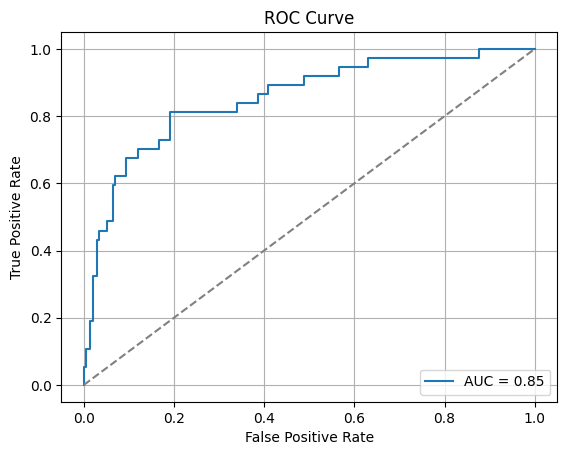

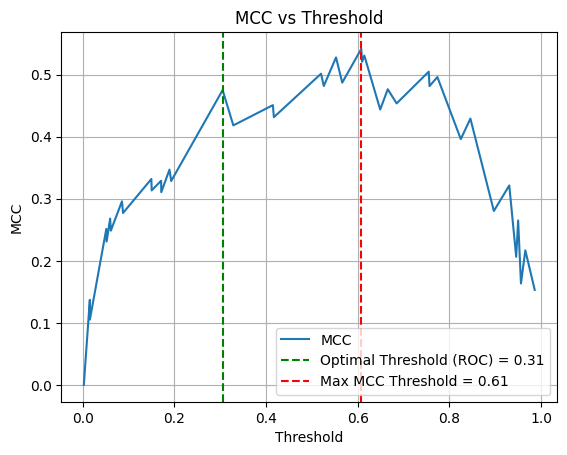

{'model': <Sequential name=sequential_16, built=True>,
 'scaler': StandardScaler(),
 'optimal_threshold': 0.3051265,
 'maximal_threshold': 0.60769814,
 'auc': 0.8533640023001725,
 'mcc': 0.4751023402763431,
 'log_loss': 0.3514379255243728,
 'history': {'AUC': [0.6972863674163818,
   0.7959966063499451,
   0.8238553404808044,
   0.8345603942871094,
   0.8298949003219604,
   0.8450353741645813,
   0.8560407757759094,
   0.871788501739502,
   0.845508337020874,
   0.8697113394737244,
   0.8752204179763794,
   0.8524426817893982,
   0.900823175907135,
   0.9008103609085083,
   0.8822314739227295,
   0.8713730573654175,
   0.8684842586517334,
   0.8906612992286682,
   0.8876383304595947,
   0.8988930583000183,
   0.9027724266052246,
   0.9136629104614258,
   0.9160722494125366,
   0.9010724425315857,
   0.9086905717849731,
   0.8972122669219971,
   0.9076168537139893,
   0.9266815185546875,
   0.9037758708000183,
   0.91083163022995,
   0.919542670249939,
   0.9116241335868835,
   0.9222140

In [42]:
neural_networks(df1)
#model_wine(df2)

In [69]:
wine_model = load_model('wine_quality_model.keras')
scaler = joblib.load('scaler.pkl')

In [70]:
sample = df2.drop('quality', axis=1).sample(1, random_state=42)

In [71]:
sample_scaled = scaler.transform(sample)
predicted_quality = wine_model.predict(sample_scaled)

print(f"\nInput data:\n{sample}")
print(f"\nPredicted wine quality (1–10 scale): {predicted_quality[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Input data:
     fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
149            7.2              0.32         0.47             5.1      0.044   

     free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
149                 19.0                  65.0    0.991  3.03       0.41   

     alcohol  
149     12.6  

Predicted wine quality (1–10 scale): 6.87
